In [16]:
import os
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))  # This will show your GPU name if available

2.4.1+cu118
True
NVIDIA GeForce RTX 3060 Ti


In [101]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import pandas as pd
from PIL import Image
import os
from torchvision.models import resnet50, ResNet50_Weights, resnet101, ResNet101_Weights
import numpy as np 
from sklearn.model_selection import train_test_split
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import roc_auc_score, classification_report,precision_recall_fscore_support,roc_curve, auc
from tqdm import tqdm
import albumentations as A
from pathlib import Path
import shutil
from typing import List, Dict, Optional, Generator
import logging
import json
from datetime import datetime
import matplotlib.pyplot as plt

In [18]:
csv = 'train-metadata.csv'
df_train_meta = pd.read_csv(csv)

print(len(df))
print(len(df[df['target'] == 1]))
print(len(df[df['target'] == 0] ))

BASE_DATA_DIR = "."
BASE_IMG_DIR = os.path.join(BASE_DATA_DIR, "train-image/image")

df_train_meta["filepath"] = df_train_meta["isic_id"].apply(lambda x: f"{BASE_IMG_DIR}/{x}.jpg")



/tmp/ipykernel_218931/2813876217.py:2: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train_meta = pd.read_csv(csv)


401059
393
400666


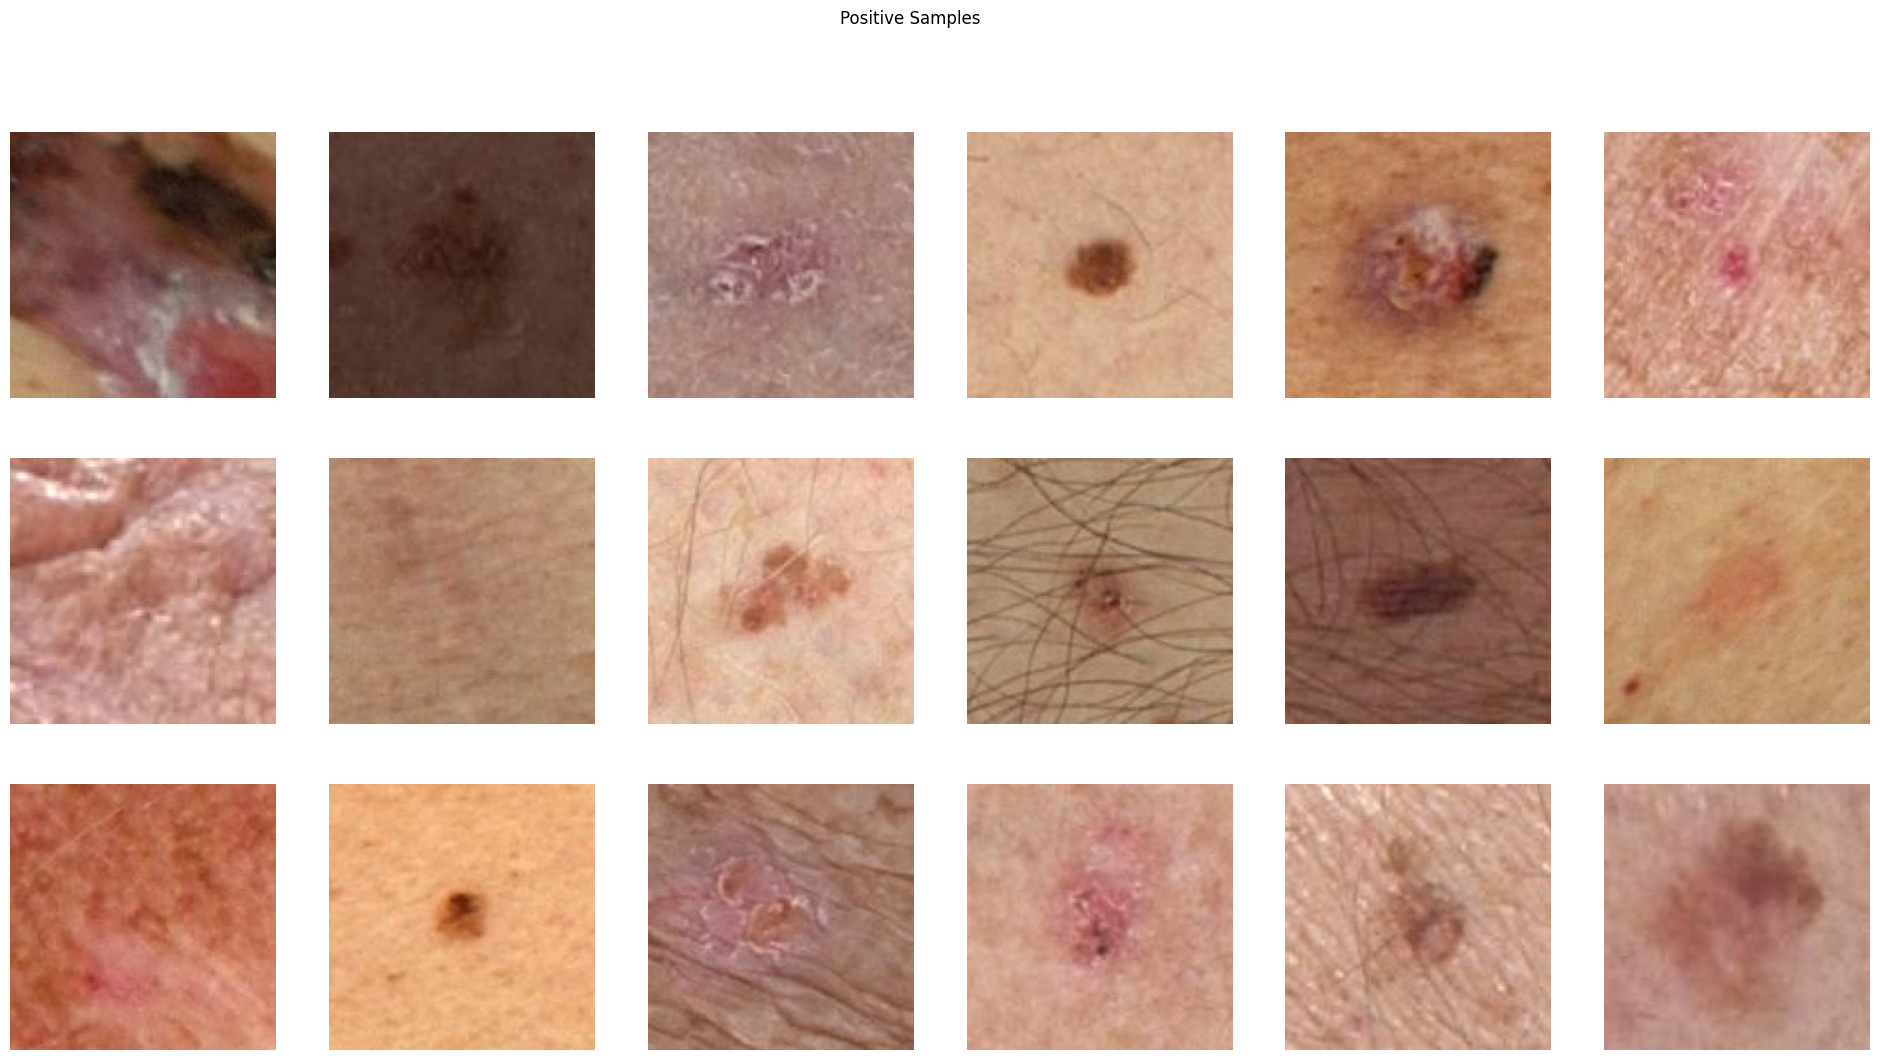

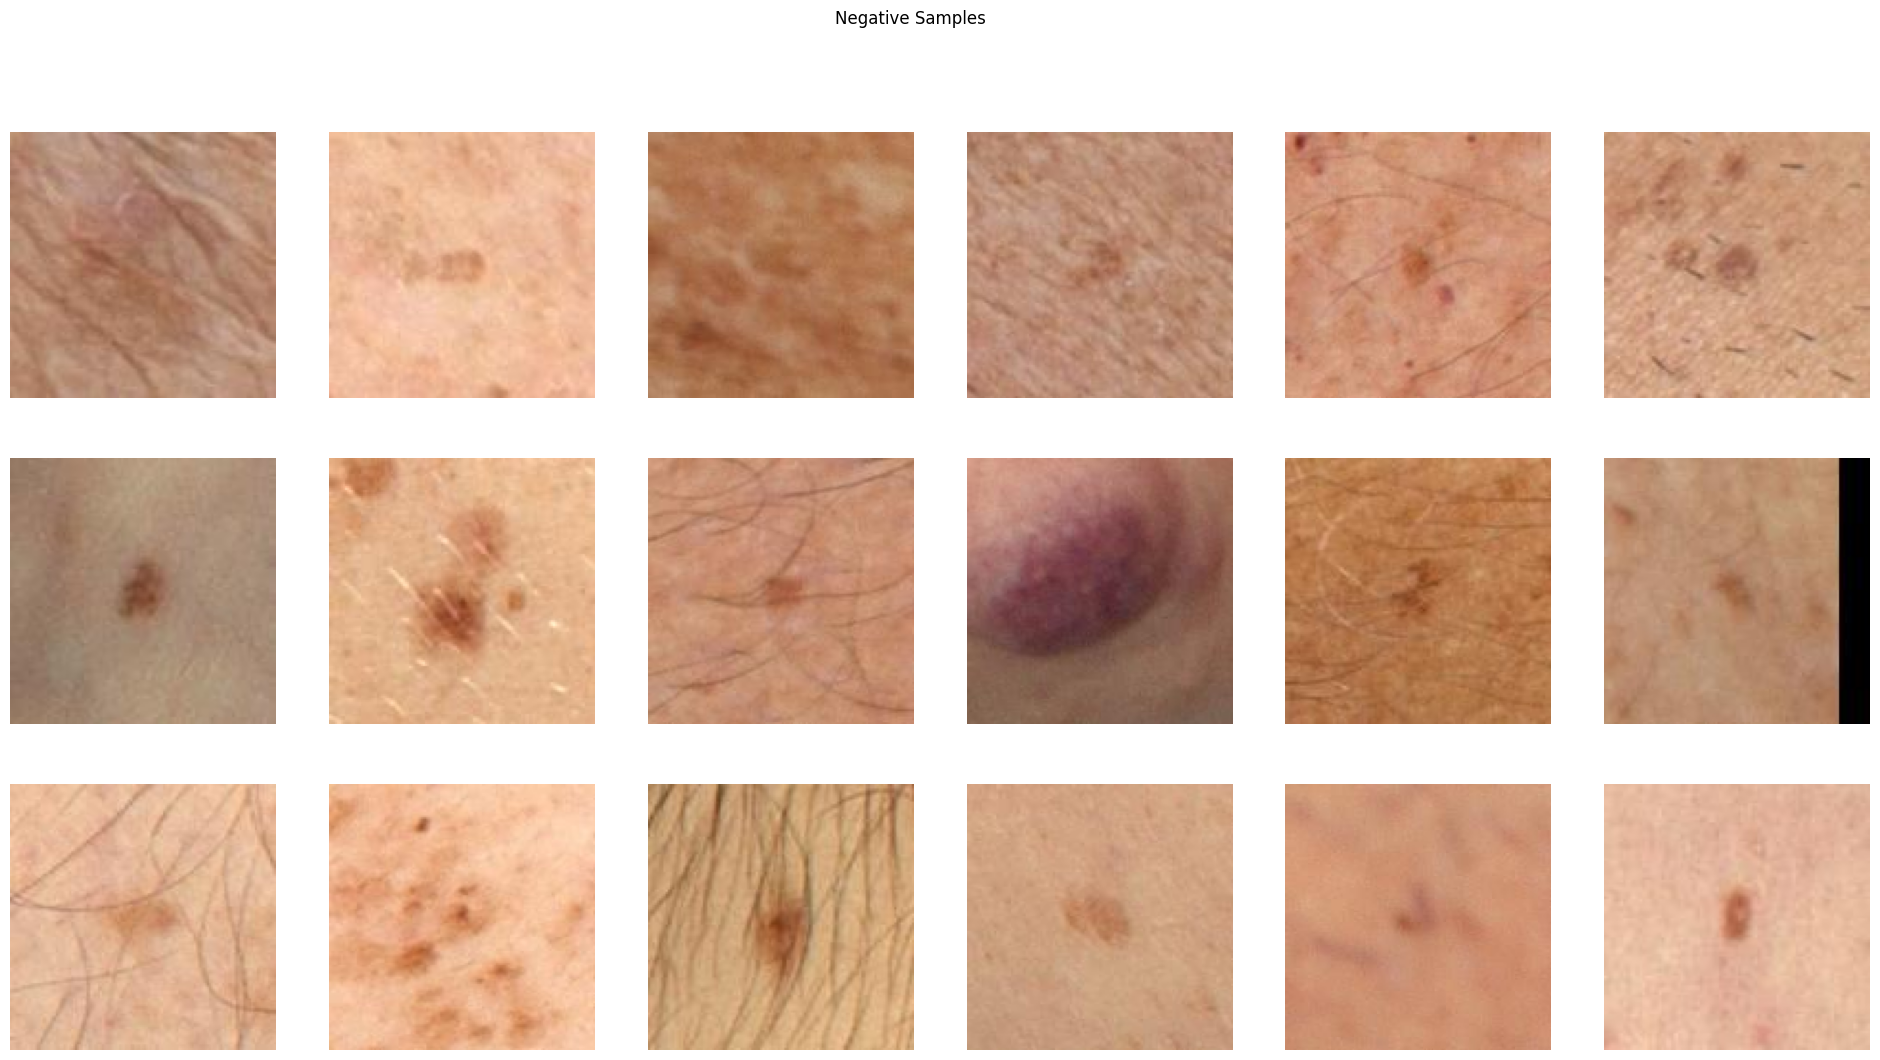

In [19]:
sample_image_paths = df_train_meta[df_train_meta["target"] == 1].sample(18, random_state=1)["filepath"].values
positive_images = [read_image(img_path) for img_path in sample_image_paths]
nrows, ncols = 3, 6
fig, axes = plt.subplots(nrows, ncols, figsize=(24, 12))
axes = axes.ravel()
for image, ax in zip(positive_images, axes):
    ax.imshow(image)
    ax.axis("off")
fig.suptitle("Positive Samples")
plt.show()

sample_image_paths = df_train_meta[df_train_meta["target"] == 0].sample(18, random_state=1)["filepath"].values
negative_images = [read_image(img_path) for img_path in sample_image_paths]
fig, axes = plt.subplots(nrows, ncols, figsize=(24, 12))
axes = axes.ravel()
for image, ax in zip(negative_images, axes):
    ax.imshow(image)
    ax.axis("off")
fig.suptitle("Negative Samples")
plt.show()

/home/davis/miniconda3/envs/cv/lib/python3.8/site-packages/pydantic/main.py:212: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


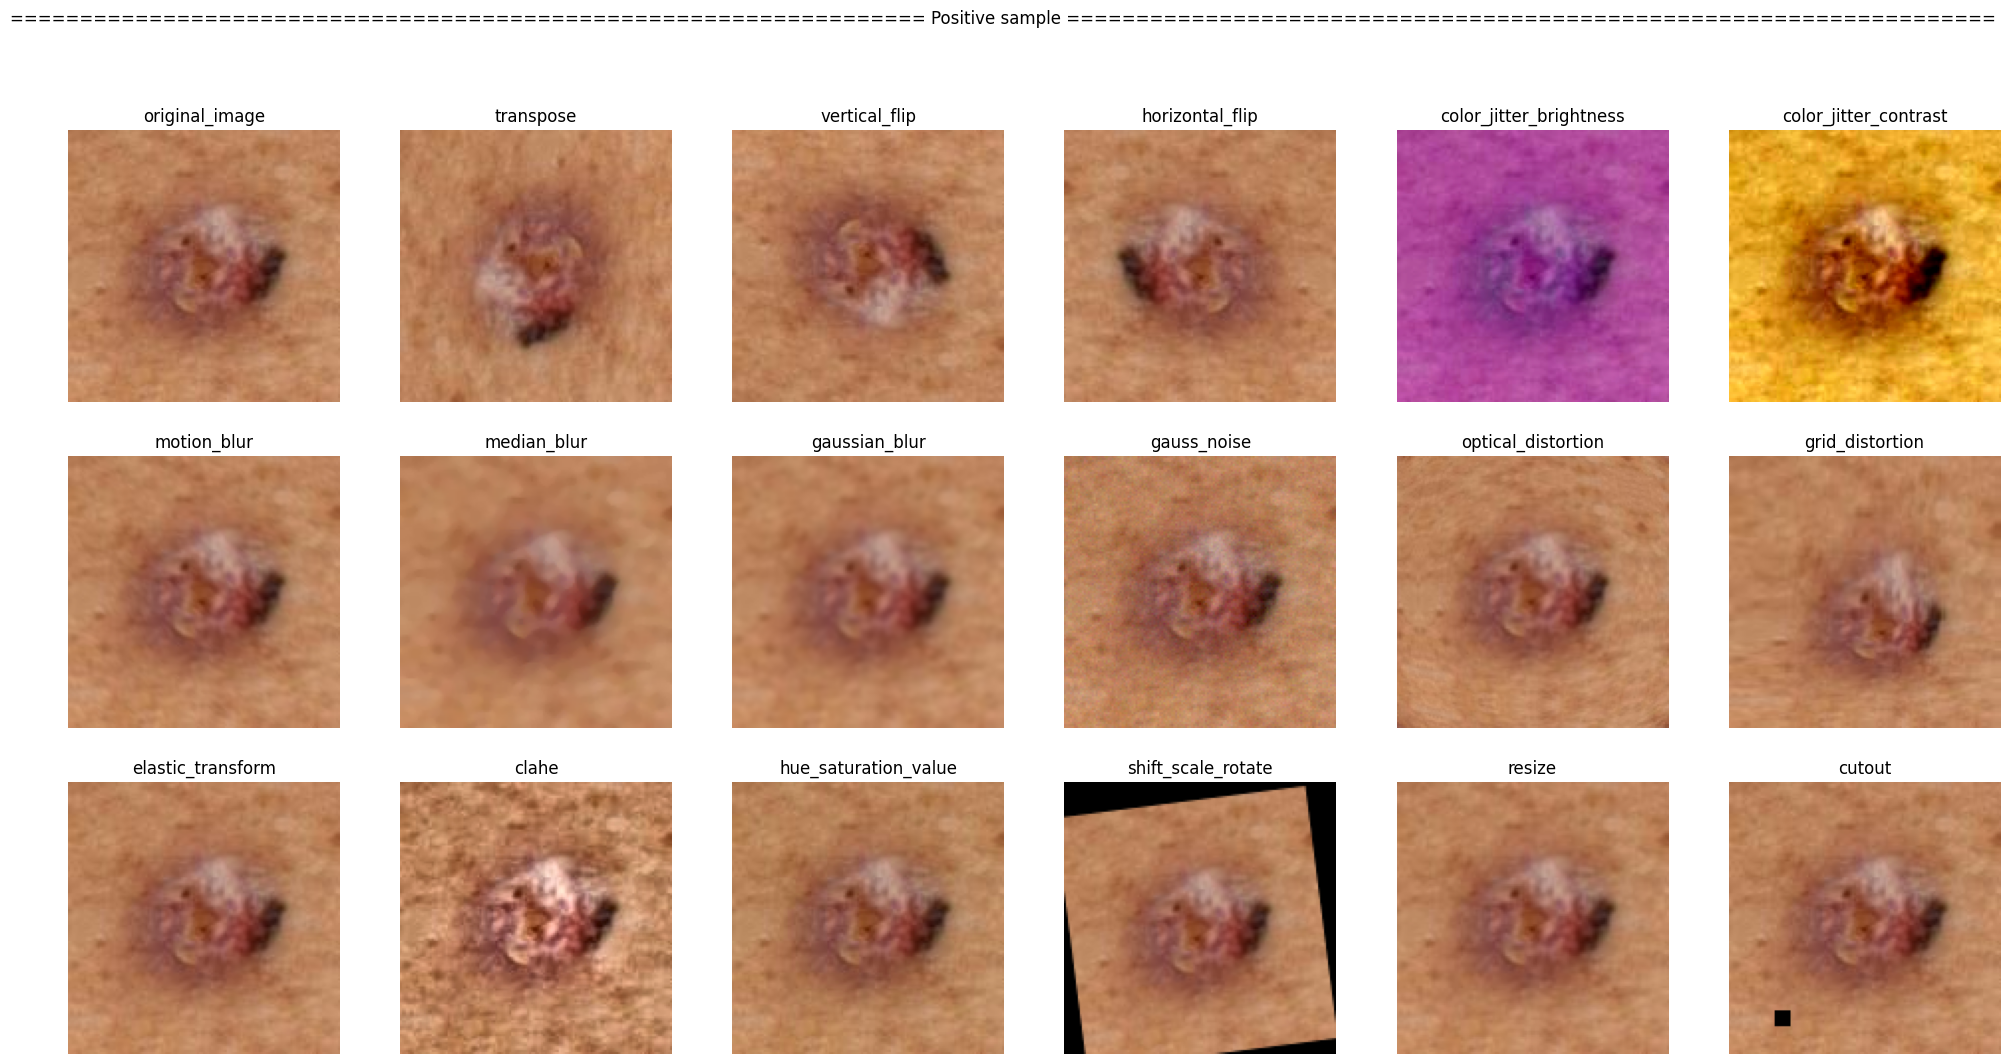

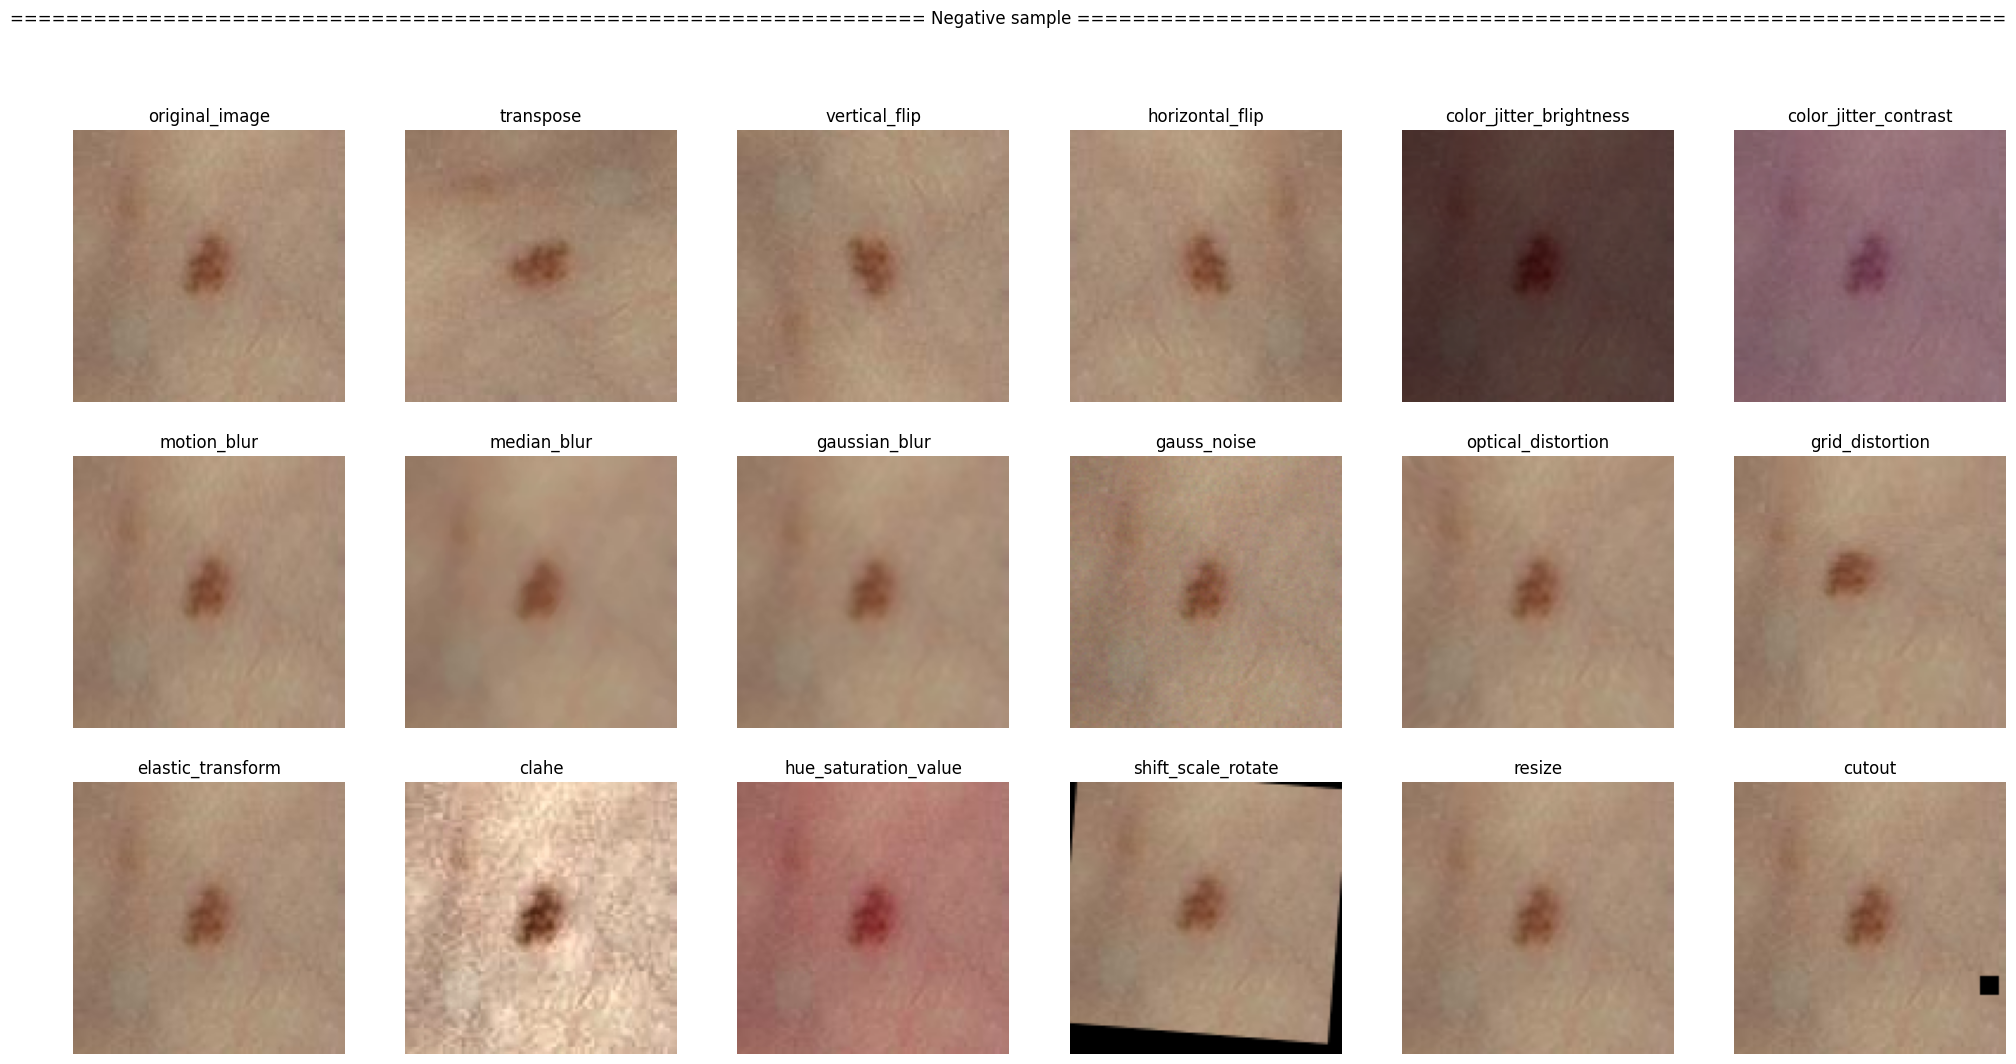

In [20]:
image_size = 128
def read_image(filepath):
    return cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)

augmentations_to_display = [
    ("original_image", lambda image: {"image": image}),
    ("transpose", A.Transpose(p=1.0)),
    ("vertical_flip", A.VerticalFlip(p=1.0)),
    ("horizontal_flip", A.HorizontalFlip(p=1.0)),
    ("color_jitter_brightness", A.ColorJitter(brightness=1.0, p=1.0)),
    ("color_jitter_contrast", A.ColorJitter(contrast=1.0, p=1.0)),
    ("motion_blur", A.MotionBlur(blur_limit=5, p=1.0)),
    ("median_blur", A.MedianBlur(blur_limit=5, p=1.0)),
    ("gaussian_blur", A.GaussianBlur(blur_limit=5, p=1.0)),
    ("gauss_noise", A.GaussNoise(var_limit=(5.0, 30.0), p=1.0)),
    ("optical_distortion", A.OpticalDistortion(distort_limit=1.0, p=1.0)),
    ("grid_distortion", A.GridDistortion(num_steps=5, distort_limit=0.5, p=1.0)),
    ("elastic_transform", A.ElasticTransform(alpha=3, p=1.0)),
    ("clahe", A.CLAHE(clip_limit=4.0, p=1.0)),
    ("hue_saturation_value", A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=1.0)),
    ("shift_scale_rotate", A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=1.0)),
    ("resize", A.Resize(image_size, image_size)),
    ("cutout", A.CoarseDropout(p=1.0)),
]

def apply_augmentation(fn, image):
    return fn(image=image)["image"]

def display_augmented_images(image, title_text, augmentations, nrows=3, ncols=6, figsize=(25, 12)):    
    title = f" {title_text} ".center(150, "=")
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.ravel()
    augmented_images = [(name, apply_augmentation(aug_fn, image)) for name, aug_fn in augmentations]    
    for (name, image), ax in zip(augmented_images, axes):
        ax.imshow(image)
        ax.axis("off")
        ax.set_title(name)
    fig.suptitle(title)
    plt.show()

positive_image = positive_images[4]
negative_image = negative_images[6]
display_augmented_images(positive_image, "Positive sample", augmentations_to_display)
display_augmented_images(negative_image, "Negative sample", augmentations_to_display)

In [30]:
import logging
from pathlib import Path
import pandas as pd
import cv2
import numpy as np
import albumentations as A
from datetime import datetime
import json
from tqdm import tqdm

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class ImageAugmentationGenerator:
    """Generate and save augmented images for imbalanced datasets"""
    
    def __init__(self, 
                 input_dir: str,
                 output_dir: str,
                 csv_file: str,
                 image_size: tuple = (224, 224),
                 num_augmentations: int = 7):
        self.input_dir = Path(input_dir)
        self.output_dir = Path(output_dir)
        self.image_size = image_size
        self.num_augmentations = num_augmentations
        
        # Load and split data
        self.df = pd.read_csv(csv_file)
        self.minority_df = self.df[self.df['target'] == 1]
        self.majority_df = self.df[self.df['target'] == 0]
        
        logger.info(f"Found {len(self.minority_df)} minority class images")
        logger.info(f"Found {len(self.majority_df)} majority class images")
        

        self.transform  = A.Compose([
        A.Transpose(p=0.5),
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(
            brightness_limit=0.2,
            contrast_limit=0.2,
            p=0.75
         ),
        A.OneOf([
            A.MotionBlur(blur_limit=5),
            A.MedianBlur(blur_limit=5),
            A.GaussianBlur(blur_limit=5),
            A.GaussNoise(var_limit=(5.0, 30.0)),
        ], p=0.7),

        A.OneOf([
            A.OpticalDistortion(distort_limit=0.75),
            A.GridDistortion(num_steps=5, distort_limit=0.75),
            A.ElasticTransform(alpha=3),
        ], p=0.7),

        A.CLAHE(clip_limit=4.0, p=0.7),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
        A.Resize(image_size[0],image_size[1]),

        A.CoarseDropout(p=1.0),
        A.Normalize()
    ])
        # Create output directories
        self.output_dir.mkdir(parents=True, exist_ok=True)
        (self.output_dir / 'original').mkdir(exist_ok=True)
        (self.output_dir / 'augmented').mkdir(exist_ok=True)
        
    def process_image(self, image_name: str, is_minority: bool = False) -> list:
        """Process a single image and its augmentations"""
        results = []
        try:
            # Load and preprocess image
            img_path = self.input_dir / f"{image_name}.jpg"
            if not img_path.exists():
                logger.warning(f"Image not found: {img_path}")
                return results
                
            image = cv2.imread(str(img_path))
            if image is None:
                logger.warning(f"Failed to load image: {img_path}")
                return results
                
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, self.image_size)
            
            # Save original image
            orig_save_path = self.output_dir / 'original' / f"{image_name}.jpg"
            cv2.imwrite(str(orig_save_path), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
            
            results.append({
                'original_name': image_name,
                'path': str(orig_save_path),
                'label': 1 if is_minority else 0,
                'is_augmented': False
            })
            
            # Generate augmentations for minority class
            if is_minority:
                for aug_idx in range(self.num_augmentations):
                    augmented = self.transform(image=image)['image']
                    aug_name = f"{image_name}_aug_{aug_idx}"
                    aug_save_path = self.output_dir / 'augmented' / f"{aug_name}.jpg"
                    
                    cv2.imwrite(str(aug_save_path), cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))
                    
                    results.append({
                        'original_name': image_name,
                        'augmented_name': aug_name,
                        'path': str(aug_save_path),
                        'label': 1,
                        'is_augmented': True
                    })
            else:
                augmented = self.transform(image=image)['image']
                aug_name = f"{image_name}_aug_0"
                aug_save_path = self.output_dir / 'augmented' / f"{aug_name}.jpg"
                
                cv2.imwrite(str(aug_save_path), cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))
                
                results.append({
                    'original_name': image_name,
                    'augmented_name': aug_name,
                    'path': str(aug_save_path),
                    'label': 0,
                    'is_augmented': True
                }) 
                    
        except Exception as e:
            logger.error(f"Error processing image {image_name}: {str(e)}")
            
        return results

    def generate_augmentations(self):
        """Generate and save augmented images"""
        all_results = []
        
        # Process minority class with augmentations
        logger.info("Processing minority class images with augmentations...")
        for _, row in tqdm(self.minority_df.iterrows(), total=len(self.minority_df)):
            results = self.process_image(row['isic_id'], is_minority=True)
            all_results.extend(results)
        
        # Process majority class without augmentations
        logger.info("Processing majority class images...")
        for _, row in tqdm(self.majority_df.iterrows(), total=len(self.majority_df)):
            results = self.process_image(row['isic_id'], is_minority=False)
            all_results.extend(results)
        
        # Save final results and metadata
        final_df = pd.DataFrame(all_results)
        final_df.to_csv(self.output_dir / 'augmented_dataset.csv', index=False)
        
        metadata = {
            'timestamp': datetime.now().isoformat(),
            'image_size': self.image_size,
            'num_augmentations': self.num_augmentations,
            'statistics': {
                'original_images': len(final_df[~final_df['is_augmented']]),
                'augmented_images': len(final_df[final_df['is_augmented']]),
                'total_images': len(final_df)
            }
        }
        
        with open(self.output_dir / 'metadata.json', 'w') as f:
            json.dump(metadata, f, indent=2)
            
        logger.info(f"Final dataset statistics:")
        logger.info(f"Original images: {metadata['statistics']['original_images']}")
        logger.info(f"Augmented images: {metadata['statistics']['augmented_images']}")
        logger.info(f"Total images: {metadata['statistics']['total_images']}")
        
        return self.output_dir / 'augmented_dataset.csv'

def generate_augmented_dataset(
    input_dir: str,
    output_dir: str,
    csv_file: str,
    num_augmentations: int = 7
) -> str:
    """
    Generate augmented dataset and return path to new CSV file
    """
    generator = ImageAugmentationGenerator(
        input_dir=input_dir,
        output_dir=output_dir,
        csv_file=csv_file,
        num_augmentations=num_augmentations
    )
    
    return generator.generate_augmentations()

if __name__ == "__main__":
    # Configure paths
    INPUT_DIR = "train-image/image"
    OUTPUT_DIR = "train-image/image_augmented"
    CSV_FILE = "train-metadata.csv"
    
    # Generate augmented dataset
    augmented_csv = generate_augmented_dataset(
        input_dir=INPUT_DIR,
        output_dir=OUTPUT_DIR,
        csv_file=CSV_FILE,
        num_augmentations=7
    )
    
    print(f"Augmented dataset saved to: {augmented_csv}")

/tmp/ipykernel_218931/2096637329.py:29: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(csv_file)
INFO:__main__:Found 393 minority class images
INFO:__main__:Found 400666 majority class images
/home/davis/miniconda3/envs/cv/lib/python3.8/site-packages/pydantic/main.py:212: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)
INFO:__main__:Processing minority class images with augmentations...
100%|█████████████████████████████████████████████████████████████████████████████| 393/393 [00:24<00:00, 16.31it/s]
INFO:__main__:Processing majority class images...
100%|█████████████████████████████████████████████████████████████████████| 400666/400666 [2:14:48<00:00, 49.53it/s]
INFO:__main__:Final dataset statistics:
INFO:__main__:Original images: 401059
INFO:

Augmented dataset saved to: train-image/image_augmented/augmented_dataset.csv


In [32]:

# updated_df = add_new_augmentations(df, label_1_originals, num_new_augs=2)

# # 4. Save the updated DataFrame
# updated_df.to_csv('jpeg/train_augmented/updated_dataset.csv', index=False)
updated_df= pd.read_csv('train-image/image_augmented/augmented_dataset.csv')
# Print summary
print("\nOriginal dataset size:", len(df))
print("Updated dataset size:", len(updated_df))
print("Added augmentations:", len(updated_df) - len(df))

# Verification
def verify_augmentations(df):
    print(len(df))
    print(len(df[df['is_augmented']]))
    print(len(df[~df['is_augmented']]))

verify_augmentations(updated_df)


Original dataset size: 401059
Updated dataset size: 804476
Added augmentations: 403417
804476
403417
401059
